# Single-cell imaging denoising Autoencoder

This is a basic implementation of a denoising, deep-convolutional Autoencoder that can be used to extract orthogonal features from images of populations of single-cells. This project is still in the making so nothing is final.

TODO
- implement orthogonality constraint
- experiment with architectures : image -> denoising -> DC -> dense -> bottleneck -> dense -> DC -> image
- scale up to larger images (input images should be also convoluted, i.e. with 500x500 windows. the smaller the window, the smaller the population effect.

[Hinton and Salakhutdinov](http://science.sciencemag.org/content/313/5786/504), [Vincent, *et al.*](https://dl.acm.org/citation.cfm?id=1390294) and [Kingma and Welling)](https://arxiv.org/abs/1312.6114).

We used Keras to set up the simple denoising, deep convolutional autoencoding network.

The Encoder uses

* some convolutional layers with max-pooling,
* two dense layers,
* relu activations

The Decoder uses

* pretty much the same in reverse,
* upsampling instead of max-pooling,
* a sigmoid activation function in the last layer.

We used AdaDelta as optimizer with standard parameters, the cross-entropy as loss and batches of size 64.
For the basic setup, we dont use batch-normalization, dropout, etc.

We use roughly 10000 images of dimension $149 \times 200$ and a single channel.
The autoencoder, with this architecture and parameterization, did not manage to reproduce the images at all. 
To be continued!

We load some libraries first.

In [1]:
import numpy

import keras
from keras.layers import *
from keras.models import Model, Sequential
from keras import backend as K
from keras.datasets import mnist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Using TensorFlow backend.


In [2]:
plt.style.use(["seaborn-whitegrid"])
plt.rcParams['font.sans-serif'] = 'Lucida Grande'
plt.rcParams['figure.figsize'] = [10, 5]

### Data

We already preprocessed the data and saved them as a numpy array.

In [3]:
dat = "_data/images.npy"

In [4]:
X = numpy.load(dat)
# Scaling to 0-1
X /= np.max(X)
X = X[:, :, :, 0]
X = np.expand_dims(X, axis=3)

In [5]:
np.max(X)

1.0

In [6]:
X.shape

(9232, 149, 200, 1)

Let's have a look at some images. Since in this notebook, we will only train on the first channel, we also only show it.

/Users/simondi/miniconda3/envs/ml/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


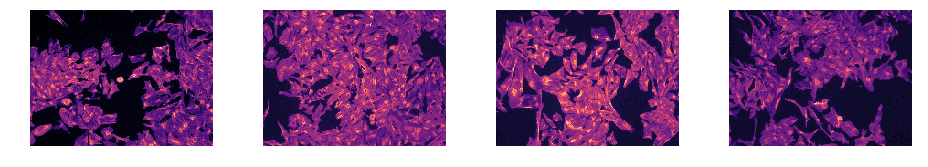

In [7]:
ncol = 4
f,ax = plt.subplots(ncols=ncol, figsize=(ncol*4, 2.5))
for i in range(ncol):
    ax[i].imshow(X[i,:,:,0] / 255, cmap="magma")
    ax[i].axis('off')
plt.show()
plt.close()

### MNIST test

We first test the autoencoder on the minst data.

In [8]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [9]:
nrow, ncol, nchan = x_train[0].shape
print(nrow, ncol, nchan)

28 28 1


 For that the architecture could look like this (from [here](https://blog.keras.io/building-autoencoders-in-keras.html)).

In [10]:
input_img = Input(shape=(nrow, ncol, nchan))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoder = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoder)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoder = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoder)
autoencoder.summary()
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
__________

In [11]:
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 74s 1ms/step - loss: 0.2184 - val_loss: 0.1656
Epoch 2/20
60000/60000 [==============================] - 73s 1ms/step - loss: 0.1589 - val_loss: 0.1532
Epoch 3/20
60000/60000 [==============================] - 82s 1ms/step - loss: 0.1430 - val_loss: 0.1353
Epoch 4/20
60000/60000 [==============================] - 100s 2ms/step - loss: 0.1336 - val_loss: 0.1282
Epoch 5/20
60000/60000 [==============================] - 72s 1ms/step - loss: 0.1281 - val_loss: 0.1255
Epoch 6/20
60000/60000 [==============================] - 75s 1ms/step - loss: 0.1242 - val_loss: 0.1199
Epoch 7/20
60000/60000 [==============================] - 73s 1ms/step - loss: 0.1210 - val_loss: 0.1192
Epoch 8/20
60000/60000 [==============================] - 73s 1ms/step - loss: 0.1189 - val_loss: 0.1163
Epoch 9/20
60000/60000 [==============================] - 73s 1ms/step - loss: 0.1168 - val_loss: 0.1136
Epoc

In [12]:
restored_images = autoencoder.predict(x_test[:10])

/Users/simondi/miniconda3/envs/ml/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


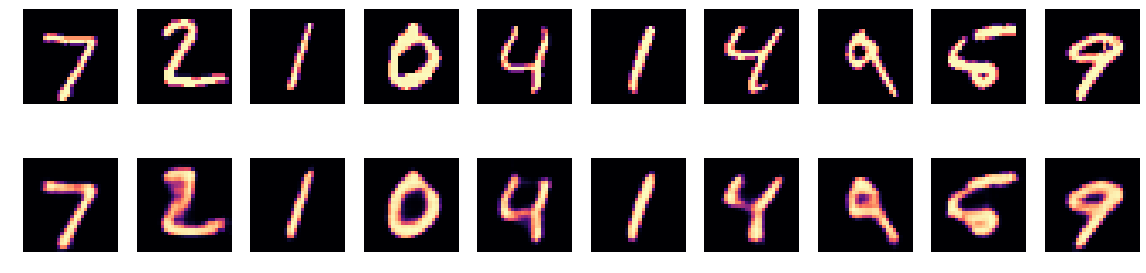

In [13]:
f, ax = plt.subplots(ncols=10, nrows=2, figsize=(20, 5))
for i in range(10):
    ax[0][i].imshow(x_test[i, :, :, 0], cmap="magma")
    ax[1][i].imshow(restored_images[i, :, :, 0], cmap="magma")
    ax[0][i].axis('off')
    ax[1][i].axis('off')
plt.show()

### Imaging autoencoder

In this section we use an autoencoder for our data. We already set up and trained the autoencoder using `sc-denoising-autoencoder.py` and only show the results here. So if you are interested in the architecture have a look at the implementation.

In [14]:
from keras.models import load_model
autoencoder = load_model("_data/trained_weights.h5")

We composed the AE using an encoder and a decoder, so the summary only shows three layers.

In [15]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 149, 200, 1)       0         
_________________________________________________________________
model_1 (Model)              (None, 100)               64128     
_________________________________________________________________
model_2 (Model)              (None, 149, 200, 1)       65173     
Total params: 129,301
Trainable params: 129,301
Non-trainable params: 0
_________________________________________________________________


In [16]:
test_idxs = np.random.choice(np.arange(9000, X.shape[0]), 10, replace=False)
restored_images = autoencoder.predict(X[np.ix_(test_idxs)])

/Users/simondi/miniconda3/envs/ml/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


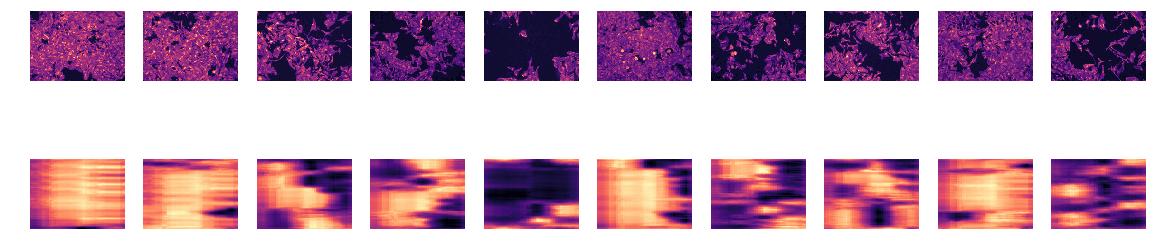

In [18]:
f, ax = plt.subplots(ncols=10, nrows=2, figsize=(20, 5))
for i in range(10):
    ax[0][i].imshow(X[test_idxs[i], :, :, 0], cmap="magma")
    ax[1][i].imshow(restored_images[i, :, :, 0], cmap="magma")
    ax[0][i].axis('off')
    ax[1][i].axis('off')
plt.show()
plt.close()